In [ ]:
!pip install giotto-tda

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 554.6/554.6 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 41.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.8/455.8 kB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 36.4 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.5.2
    Uninstalling scikit-learn-1.5.2:
      Successfully uninstalled scikit-learn-1.5.2


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision
from torchvision import models, transforms

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
#하이퍼파라미터

Batch_size = 64
Learning_rate = 0.001
Epoch = 1

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# 데이터셋 정의
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=Batch_size, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=Batch_size, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170M/170M [00:03<00:00, 46.6MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
#정확도, f1점수
from sklearn.metrics import f1_score, accuracy_score

def calculate_metrics(y_pred, y_true):
    if y_pred.ndim > 1:
        y_pred = torch.argmax(y_pred, dim=1)

    y_true_np = y_true.cpu().detach().numpy()
    y_pred_np = y_pred.cpu().detach().numpy()

    accuracy = accuracy_score(y_true_np, y_pred_np)
    f1 = f1_score(y_true_np, y_pred_np, average="weighted")

    return {"accuracy": accuracy, "f1_score": f1}

# 이미지 향상

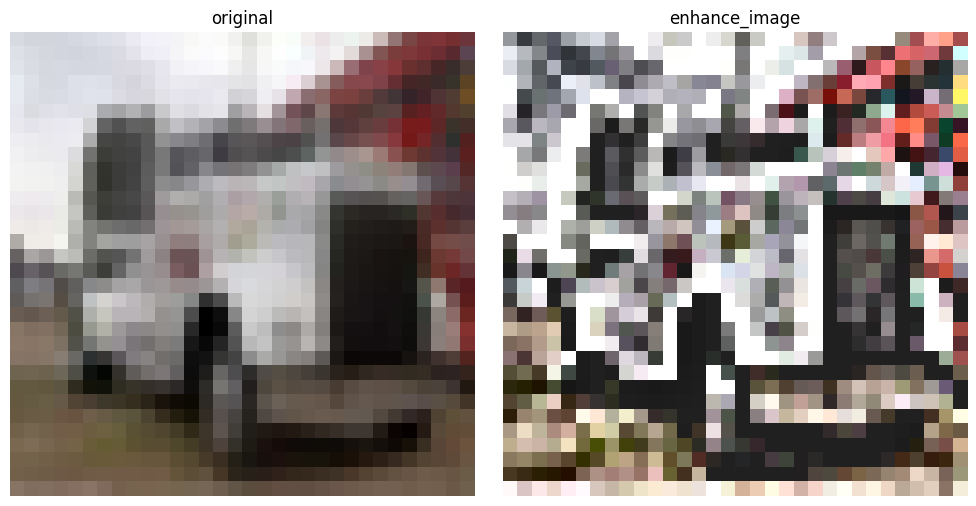

In [ ]:
import cv2

import cv2
import numpy as np
import torch

def enhance_image_data(image_data):
    # Tensor를 NumPy로 변환
    image_data = np.transpose(image_data, (0, 2, 3, 1))  # (B, C, H, W) -> (B, H, W, C)

    # -1~1을 0~255로 변환
    image_np = ((image_data + 1) * 127.5).astype(np.uint8)

    enhanced_images = []
    for img in image_np:  # 배치 내의 각 이미지에 대해 반복
        # 1. 히스토그램 평활화 (YUV 색 공간 사용)
        img_yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        img_yuv[:, :, 0] = cv2.equalizeHist(img_yuv[:, :, 0])  # Y 채널에만 적용
        img_hist_eq = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)

        # 2. 샤프닝 필터 적용
        kernel = np.array([[0, -1, 0],
                           [-1, 5, -1],
                           [0, -1, 0]])
        img_sharpened = cv2.filter2D(img_hist_eq, -1, kernel)

        # 3. CLAHE(적응형 히스토그램 평활화) 적용
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        img_lab = cv2.cvtColor(img_sharpened, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(img_lab)
        l_clahe = clahe.apply(l)
        img_clahe = cv2.merge((l_clahe, a, b))
        img_enhanced = cv2.cvtColor(img_clahe, cv2.COLOR_LAB2RGB)

        enhanced_images.append(img_enhanced)

    # NumPy 이미지를 Tensor로 변환 (B, H, W, C) -> (B, C, H, W)
    image_enhanced_tensor = torch.tensor(np.array(enhanced_images).transpose(0, 3, 1, 2), dtype=torch.float32)

    # 0~255를 -1~1로 정규화
    image_enhanced_tensor = (image_enhanced_tensor / 127.5) - 1.0

    return image_enhanced_tensor

for i, data in enumerate(trainloader, 0):
  inputs, labels = data[0].to(device), data[1].to(device)
  enhance_image = enhance_image_data(inputs.cpu().detach().numpy())

  plt.figure(figsize=(10, 5))

  plt.subplot(1, 2, 1)
  plt.imshow((inputs[0].cpu().detach().numpy().transpose(1, 2, 0)+1)/2)
  plt.title("original")
  plt.axis('off')

  plt.subplot(1, 2, 2)
  plt.imshow((enhance_image[0].permute(1, 2, 0)+1)/2)
  plt.title("enhance_image")
  plt.axis('off')

  plt.tight_layout()
  plt.show()
  break

In [ ]:
class Classification_enhance(nn.Module):
  def __init__(self):
    super(Classification_enhance, self).__init__()
    self.avgpool = nn.AdaptiveAvgPool2d(7)
    self.input_linear = nn.Linear(512*7*7, 4096)
    self.linear1 = nn.Linear(4096, 4096)
    self.linear2 = nn.Linear(4096, 4096)
    self.linear3 = nn.Linear(4096, 10)

    self.relu = nn.ReLU(inplace=True)
    self.dropout = nn.Dropout(0.5)

  def forward(self, x):
    x = self.avgpool(x)
    x = torch.flatten(x, start_dim=1)
    x = self.dropout(self.relu(self.input_linear(x)))
    x = self.dropout(self.relu(self.linear1(x)))
    x = self.dropout(self.relu(self.linear2(x)))
    x = self.linear3(x)
    return x

def classification_train_image_enhance():
  trainhis = {'loss' : [], 'acc' : [], 'f1' : []}

  vgg16 = models.vgg16(weights=models.VGG16_Weights.DEFAULT).to(device)
  classification_model = Classification_enhance()
  classification_model.to(device)

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(classification_model.parameters(), lr=Learning_rate)

  for epoch in range(Epoch):
    for i, data in enumerate(trainloader, 0):
      inputs, labels = data[0].to(device), data[1].to(device)

      vgg_out = vgg16.features(inputs)

      pred = classification_model(vgg_out)

      loss = criterion(pred, labels)

      optimizer.zero_grad()

      loss.backward()
      optimizer.step()

      train_inform = calculate_metrics(pred, labels)
      trainhis['loss'].append(loss.cpu().detach().numpy())
      trainhis['acc'].append(train_inform['accuracy'])
      trainhis['f1'].append(train_inform['f1_score'])

      if i % 100 == 0:
        print('[%d, %5d] loss: %.3f acc: %.3f f1: %.3f' % (epoch + 1, i + 1, loss, train_inform['accuracy'], train_inform['f1_score']))

    for i, data in enumerate(testloader, 0):
      inputs, labels = data[0].to(device), data[1].to(device)

      vgg_out = vgg16.features(inputs)

      pred = classification_model(vgg_out)

      test_inform = calculate_metrics(pred, labels)

      if i % 100 == 0:
        print('[%d, %5d] acc: %.3f f1: %.3f' % (epoch + 1, i + 1, test_inform['accuracy'], test_inform['f1_score']))

    torch.save(classification_model.state_dict(), 'classification_model_image_enhance_epoch_{}.pth'.format(epoch))
    print("save model")

    iterations = range(1, len(trainhis['loss']) + 1)

    # 플롯 크기 설정
    plt.figure(figsize=(10, 6))

    # Loss, Accuracy, F1 Score 플롯
    plt.plot(iterations, trainhis['loss'], label="Loss", color="blue")
    plt.plot(iterations, trainhis['acc'], label="Accuracy", color="green")
    plt.plot(iterations, trainhis['f1'], label="F1 Score", color="red")

    # 그래프 제목 및 축 설정
    plt.title("Training Metrics Over Iterations")
    plt.xlabel("Iterations")
    plt.ylabel("Metrics")
    plt.legend()
    plt.grid(True)

    # 플롯 출력
    plt.show()


In [ ]:
def test_image_enhance():
    acc_his = []
    f1_his = []
    acc_his_enhanced = []
    f1_his_enhanced = []

    avg_acc = 0
    avg_f1 = 0
    avg_acc_enhanced = 0
    avg_f1_enhanced = 0

    vgg16 = models.vgg16(weights=models.VGG16_Weights.DEFAULT).to(device)

    classification_model = Classification_enhance()
    classification_model.to(device)

    classification_model.load_state_dict(torch.load('classification_model_image_enhance_epoch_0.pth'))

    for i, data in enumerate(testloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        # 원본 이미지 처리
        vgg_out = vgg16.features(inputs)
        pred = classification_model(vgg_out)

        # 향상된 이미지 처리
        enhanced_images = enhance_image_data(inputs.cpu().detach().numpy()).to(device)
        enhance_vgg_out = vgg16.features(enhanced_images)
        enhance_pred = classification_model(enhance_vgg_out)

        # 메트릭 계산
        test_inform = calculate_metrics(pred, labels)
        test_inform_enhance = calculate_metrics(enhance_pred, labels)

        # 출력
        print('Original - acc: %.3f f1: %.3f' % (test_inform['accuracy'], test_inform['f1_score']))
        print('Enhanced - acc: %.3f f1: %.3f' % (test_inform_enhance['accuracy'], test_inform_enhance['f1_score']))

        # 히스토리 업데이트
        acc_his.append(test_inform['accuracy'])
        f1_his.append(test_inform['f1_score'])
        acc_his_enhanced.append(test_inform_enhance['accuracy'])
        f1_his_enhanced.append(test_inform_enhance['f1_score'])

    # 평균 계산
    avg_acc = sum(acc_his) / len(acc_his) if acc_his else 0
    avg_f1 = sum(f1_his) / len(f1_his) if f1_his else 0
    avg_acc_enhanced = sum(acc_his_enhanced) / len(acc_his_enhanced) if acc_his_enhanced else 0
    avg_f1_enhanced = sum(f1_his_enhanced) / len(f1_his_enhanced) if f1_his_enhanced else 0

    print('Original Average - Accuracy: %.3f, F1-Score: %.3f' % (avg_acc, avg_f1))
    print('Enhanced Average - Accuracy: %.3f, F1-Score: %.3f' % (avg_acc_enhanced, avg_f1_enhanced))

    # 그래프 그리기
    plt.figure(figsize=(12, 6))

    plt.plot(acc_his, label='Original Accuracy', color='blue')
    plt.plot(f1_his, label='Original F1 Score', color='green')
    plt.plot(acc_his_enhanced, label='Enhanced Accuracy', color='orange')
    plt.plot(f1_his_enhanced, label='Enhanced F1 Score', color='red')

    plt.title('Comparison of Original and Enhanced Image Metrics')
    plt.xlabel('Iteration')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)
    plt.show()

[1,     1] loss: 2.294 acc: 0.062 f1: 0.059
[1,   101] loss: 1.618 acc: 0.438 f1: 0.426
[1,   201] loss: 1.341 acc: 0.547 f1: 0.519
[1,   301] loss: 1.365 acc: 0.594 f1: 0.572
[1,   401] loss: 1.668 acc: 0.484 f1: 0.487
[1,   501] loss: 1.438 acc: 0.547 f1: 0.548
[1,   601] loss: 1.470 acc: 0.609 f1: 0.596
[1,   701] loss: 1.531 acc: 0.484 f1: 0.454
[1,     1] acc: 0.422 f1: 0.446
[1,   101] acc: 0.484 f1: 0.479
save model


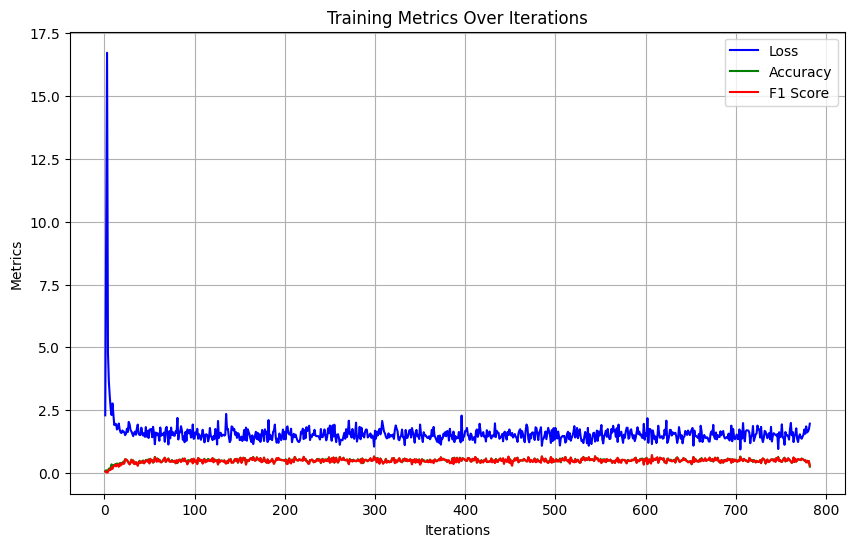

In [ ]:
classification_train_image_enhance()

<ipython-input-30-6cbd37f07225>:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  classification_model.load_state_dict(torch.load('classification_model_image_enhance_epoch_0

Original - acc: 0.406 f1: 0.403
Enhanced - acc: 0.219 f1: 0.186
Original - acc: 0.422 f1: 0.428
Enhanced - acc: 0.188 f1: 0.173
Original - acc: 0.391 f1: 0.369
Enhanced - acc: 0.188 f1: 0.152
Original - acc: 0.500 f1: 0.490
Enhanced - acc: 0.188 f1: 0.181
Original - acc: 0.391 f1: 0.384
Enhanced - acc: 0.281 f1: 0.263
Original - acc: 0.438 f1: 0.408
Enhanced - acc: 0.219 f1: 0.187
Original - acc: 0.500 f1: 0.486
Enhanced - acc: 0.109 f1: 0.141
Original - acc: 0.547 f1: 0.541
Enhanced - acc: 0.141 f1: 0.103
Original - acc: 0.438 f1: 0.473
Enhanced - acc: 0.234 f1: 0.192
Original - acc: 0.562 f1: 0.557
Enhanced - acc: 0.328 f1: 0.267
Original - acc: 0.578 f1: 0.579
Enhanced - acc: 0.156 f1: 0.126
Original - acc: 0.406 f1: 0.413
Enhanced - acc: 0.172 f1: 0.105
Original - acc: 0.359 f1: 0.357
Enhanced - acc: 0.234 f1: 0.226
Original - acc: 0.484 f1: 0.498
Enhanced - acc: 0.156 f1: 0.174
Original - acc: 0.625 f1: 0.630
Enhanced - acc: 0.219 f1: 0.215
Original - acc: 0.484 f1: 0.512
Enhanced

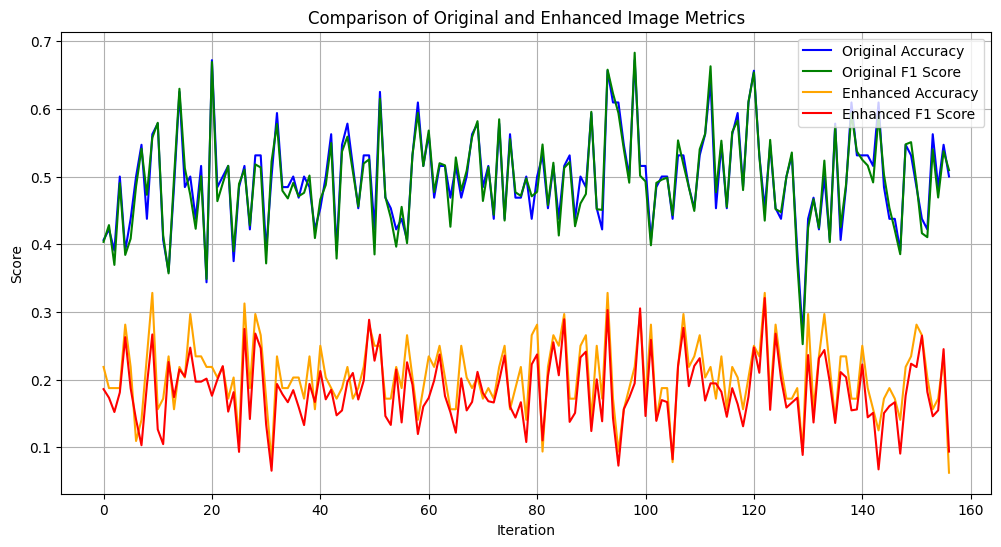

In [ ]:
test_image_enhance()

# TDA

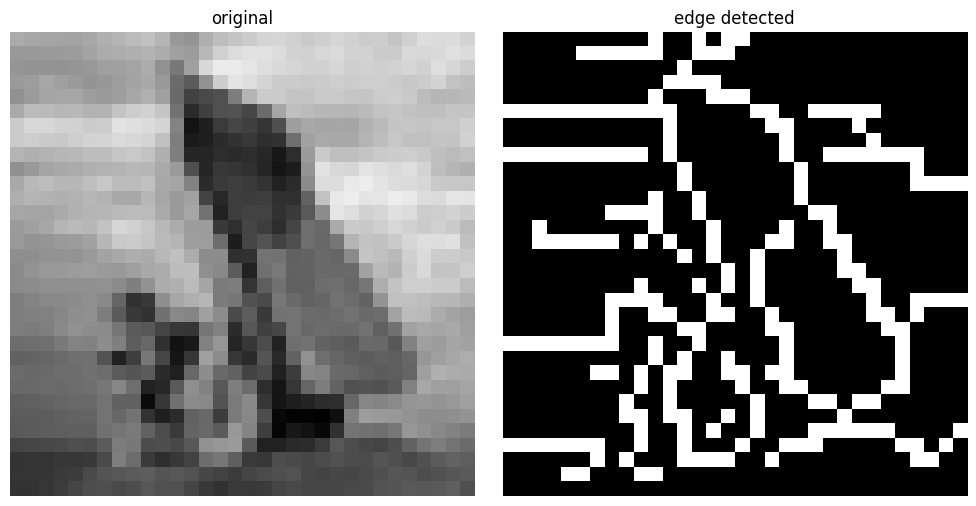

In [ ]:
#테두리 추출

import cv2

def detect_edge(image_data):
  image_data = np.transpose(image_data, (0, 2, 3, 1))

  edge_images = []
  for img in image_data:
    img = ((img + 1)/2*255).astype(np.uint8)
    img = np.nan_to_num(img, nan=0, posinf=255, neginf=0)
    gray_image = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    edge_image = cv2.Canny(gray_image, threshold1=100, threshold2=200)
    edge_image = np.nan_to_num(edge_image, nan=0, posinf=1, neginf=0)
    edge_images.append(edge_image[np.newaxis, :, :])

  return np.array(edge_images)

for i, data in enumerate(trainloader, 0):
  inputs, labels = data[0].to(device), data[1].to(device)
  edge_images = detect_edge(inputs.cpu().detach().numpy())

  plt.figure(figsize=(10, 5))

  plt.subplot(1, 2, 1)
  plt.imshow((inputs[0].cpu().detach().numpy().transpose(1, 2, 0)+1)/2)
  plt.title("original")
  plt.axis('off')

  plt.subplot(1, 2, 2)
  plt.imshow(edge_images[0].transpose(1, 2, 0).astype(np.float32), cmap='gray')
  plt.title("edge detected")
  plt.axis('off')

  plt.tight_layout()
  plt.show()
  break


In [ ]:
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset
# 테두리 이미지로 위상적 데이터 분석

def process_single_image(image, tda_union):
  image = np.nan_to_num(image, nan=0, posinf=1, neginf=0)
  return tda_union.fit_transform(image)

def make_tda(edge_images):
  from gtda.images import RadialFiltration, HeightFiltration
  from gtda.homology import CubicalPersistence
  from gtda.diagrams import Scaler, HeatKernel, PersistenceEntropy, Amplitude
  from sklearn.pipeline import make_pipeline, make_union

  direction_list = [[1, 0], [0, 1], [-1, -1]]
  center_list = [[13, 13], [20, 20]]

  filtration_list = (
      [
          HeightFiltration(direction=np.array(direction), n_jobs=1)
          for direction in direction_list
      ]
      + [RadialFiltration(center=np.array(center), n_jobs=1) for center in center_list]
  )

  diagram_steps = [
      [
          filtration,
          CubicalPersistence(n_jobs=1),
          Scaler(n_jobs=1),
      ]
      for filtration in filtration_list
  ]

  metric_list = [
    {"metric": "bottleneck", "metric_params": {}},
    {"metric": "wasserstein", "metric_params": {"p": 1}},
    {"metric": "wasserstein", "metric_params": {"p": 2}},
  ]


  feature_union = make_union(
      *[PersistenceEntropy(nan_fill_value=0)]
      + [Amplitude(**metric, n_jobs=1) for metric in metric_list]
  )

  tda_union = make_union(
      *[make_pipeline(*diagram_step, feature_union) for diagram_step in diagram_steps],
      n_jobs=1
  )

  results = make_tda_dataloader(edge_images, tda_union) # 병렬 처리 수행
  return np.array(results)

import pickle
def save_tda_data():
  edge_images = detect_edge(np.transpose(trainset.data, (0, 3, 1, 2)))
  tda = make_tda(edge_images)

  with open('train_tda.pickle', 'wb') as f:
    pickle.dump(tda, f)
    print("save tda")

def make_tda_dataloader(edge_images, tda_union, batch_size=32, num_workers=1):
    dataset = EdgeImageDataset(edge_images, tda_union)
    dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=num_workers)

    results = []
    for batch in dataloader:
        results.extend(batch)
    return np.array(results)

class EdgeImageDataset(Dataset):
    def __init__(self, images, tda_union):
        self.images = images
        self.tda_union = tda_union
        # Pre-compute TDA features and store them
        self.tda_features = [self._compute_tda_features(i) for i in range(len(self.images))]

    def _compute_tda_features(self, idx):
        image = self.images[idx]
        try:
            image = np.nan_to_num(image, nan=0, posinf=1, neginf=0)
            result = self.tda_union.fit_transform(image)
        except Exception as e:
            print(f"Error processing image at index {idx}: {e}")
            result = np.zeros((1, 40)) # 기본값 반환 (모양 일치)
        return result

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Return pre-computed TDA features
        return self.tda_features[idx]

In [ ]:
class Classification(nn.Module):
  def __init__(self):
    super(Classification, self).__init__()
    self.avgpool = nn.AdaptiveAvgPool2d(7)
    self.input_linear = nn.Linear((512*7*7)+40, 4096)
    self.linear1 = nn.Linear(4096, 4096)
    self.linear2 = nn.Linear(4096, 4096)
    self.linear3 = nn.Linear(4096, 10)

    self.relu = nn.ReLU(inplace=True)
    self.dropout = nn.Dropout(0.5)

  def forward(self, feature_out, tda):
    feature_out = self.avgpool(feature_out)
    feature_out = torch.flatten(feature_out, start_dim=1)
    x = torch.cat([feature_out, tda], dim=1)
    x = self.dropout(self.relu(self.input_linear(x)))
    x = self.dropout(self.relu(self.linear1(x)))
    x = self.dropout(self.relu(self.linear2(x)))
    x = self.linear3(x)
    return x

def classification_train():
  trainhis = {'loss':[], 'acc':[], 'f1':[]}

  vgg16 = models.vgg16(weights=models.VGG16_Weights.DEFAULT).to(device)
  classification_model = Classification()
  classification_model.to(device)

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(classification_model.parameters(), lr=Learning_rate)

  for epoch in range(Epoch):
    for i, data in enumerate(trainloader, 0):
      inputs, labels = data[0].to(device), data[1].to(device)

      vgg_out = vgg16.features(inputs)

      edge_images = detect_edge(inputs.cpu().detach().numpy())
      tda = make_tda(edge_images)
      tda = torch.tensor(tda, dtype=torch.float32).to(device)
      tda = torch.flatten(tda, start_dim=1)

      pred = classification_model(vgg_out, tda)

      loss = criterion(pred, labels)

      optimizer.zero_grad()

      loss.backward()
      optimizer.step()

      train_inform = calculate_metrics(pred, labels)
      trainhis['loss'].append(loss.cpu().detach().numpy())
      trainhis['acc'].append(train_inform['accuracy'])
      trainhis['f1'].append(train_inform['f1_score'])

      # if i % 10 == 0:
      print('[%d, %5d] loss: %.3f acc: %.3f f1: %.3f' % (epoch + 1, i + 1, loss, train_inform['accuracy'], train_inform['f1_score']))

    # for i, data in enumerate(testloader, 0):
    #   inputs, labels = data[0].to(device), data[1].to(device)

    #   vgg_out = vgg16.features(inputs)
    #   vgg_out = torch.flatten(vgg_out, start_dim=1)

    #   edge_images = detect_edge(inputs.cpu().detach().numpy())
    #   tda = make_tda(edge_images)
    #   tda = torch.tensor(tda, dtype=torch.float32).to(device)
    #   tda = torch.flatten(tda, start_dim=1)

    #   pred = classification_model(vgg_out, tda)

    #   test_inform = calculate_metrics(pred, labels.cpu().detach().numpy())

    #   if i % 10 == 0:
    #     print('[%d, %5d] acc: %.3f f1: %.3f' % (epoch + 1, i + 1, test_inform['accuracy'], test_inform['f1_score']))

    torch.save(classification_model.state_dict(), 'classification_model_tda_epoch_{}.pth'.format(epoch))
    print("save model")

    iterations = range(1, len(trainhis['loss']) + 1)

    # 플롯 크기 설정
    plt.figure(figsize=(10, 6))

    # Loss, Accuracy, F1 Score 플롯
    plt.plot(iterations, trainhis['loss'], label="Loss", color="blue")
    plt.plot(iterations, trainhis['acc'], label="Accuracy", color="green")
    plt.plot(iterations, trainhis['f1'], label="F1 Score", color="red")

    # 그래프 제목 및 축 설정
    plt.title("Training Metrics Over Iterations")
    plt.xlabel("Iterations")
    plt.ylabel("Metrics")
    plt.legend()
    plt.grid(True)

    # 플롯 출력
    plt.show()

In [ ]:
def test_tda():
    acc_his = []
    f1_his = []
    acc_his_enhanced = []
    f1_his_enhanced = []

    avg_acc = 0
    avg_f1 = 0
    avg_acc_enhanced = 0
    avg_f1_enhanced = 0

    vgg16 = models.vgg16(weights=models.VGG16_Weights.DEFAULT).to(device)

    classification_model = Classification_enhance()
    classification_model.to(device)
    classification_model.load_state_dict(torch.load('classification_model_image_enhance_epoch_0.pth'))

    classification_model_tda = Classification()
    classification_model_tda.to(device)
    classification_model_tda.load_state_dict(torch.load('classification_model_tda_epoch_0.pth'))

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        # 원본 이미지 처리
        vgg_out = vgg16.features(inputs)
        pred = classification_model(vgg_out)

        # 향상된 이미지 처리
        edge_images = detect_edge(inputs.cpu().detach().numpy())
        tda = make_tda(edge_images)
        tda = torch.tensor(tda, dtype=torch.float32).to(device)
        tda = torch.flatten(tda, start_dim=1)

        enhance_pred = classification_model_tda(vgg_out, tda)

        # 메트릭 계산
        train_inform = calculate_metrics(pred, labels)
        train_inform_enhance = calculate_metrics(enhance_pred, labels)

        # 출력
        print('Original - acc: %.3f f1: %.3f' % (train_inform['accuracy'], train_inform['f1_score']))
        print('Enhanced - acc: %.3f f1: %.3f' % (train_inform_enhance['accuracy'], train_inform_enhance['f1_score']))

        # 히스토리 업데이트
        acc_his.append(train_inform['accuracy'])
        f1_his.append(train_inform['f1_score'])
        acc_his_enhanced.append(train_inform_enhance['accuracy'])
        f1_his_enhanced.append(train_inform_enhance['f1_score'])

    # 평균 계산
    avg_acc = sum(acc_his) / len(acc_his) if acc_his else 0
    avg_f1 = sum(f1_his) / len(f1_his) if f1_his else 0
    avg_acc_enhanced = sum(acc_his_enhanced) / len(acc_his_enhanced) if acc_his_enhanced else 0
    avg_f1_enhanced = sum(f1_his_enhanced) / len(f1_his_enhanced) if f1_his_enhanced else 0

    print('Original Average - Accuracy: %.3f, F1-Score: %.3f' % (avg_acc, avg_f1))
    print('Enhanced Average - Accuracy: %.3f, F1-Score: %.3f' % (avg_acc_enhanced, avg_f1_enhanced))

    # 그래프 그리기
    plt.figure(figsize=(12, 6))

    plt.plot(acc_his, label='Original Accuracy', color='blue')
    plt.plot(f1_his, label='Original F1 Score', color='green')
    plt.plot(acc_his_enhanced, label='Enhanced Accuracy', color='orange')
    plt.plot(f1_his_enhanced, label='Enhanced F1 Score', color='red')

    plt.title('Comparison of Original and Enhanced Image Metrics')
    plt.xlabel('Iteration')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
classification_train()

KeyboardInterrupt: 

In [ ]:
test_tda()